In [12]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
from utils import *
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Bayes By Backprop

Posterior Distribution (Reparameterized Gaussian)

In [13]:
class Reparameterized_Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, weights):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((weights - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

Prior Distribution (select either Gaussian or Scaled  Mixture)

In [14]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, weights):
        prob1 = torch.exp(self.gaussian1.log_prob(weights))
        prob2 = torch.exp(self.gaussian2.log_prob(weights))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()
    
class Gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.gaussian = torch.distributions.Normal(mu,sigma)
    def log_prob(self, weights):
        prob = self.gaussian.log_prob(weights)
        return prob.sum()

Bayesian Layer

In [15]:
class BayesianLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.weight_mu = nn.Parameter(torch.Tensor(output_dim, input_dim).uniform_(-0.01, 0.01))
        self.weight_rho = nn.Parameter(torch.Tensor(output_dim, input_dim).uniform_(-3,-3))
        self.weight = Reparameterized_Gaussian(self.weight_mu, self.weight_rho)
        self.bias_mu = nn.Parameter(torch.Tensor(output_dim).uniform_(-0.01, 0.01))
        self.bias_rho = nn.Parameter(torch.Tensor(output_dim).uniform_(-4,-3))
        self.bias = Reparameterized_Gaussian(self.bias_mu, self.bias_rho)
        SIGMA_1 = torch.FloatTensor([math.exp(-0)])
        SIGMA_2 = torch.FloatTensor([math.exp(-6)])
        PI = 0.5
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

Bayesian Network

In [16]:
class BayesianNetwork(nn.Module):
    def __init__(self, input_dim, num_units, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.l1 = BayesianLayer(input_dim,num_units)
        self.l2 = BayesianLayer(num_units, num_units)
        self.l3 = BayesianLayer(num_units, 2*output_dim)
    
    def forward(self, X, sample=False):
        X = X.view(-1, self.input_dim)
        X = F.relu(self.l1(X, sample))
        X = F.relu(self.l2(X, sample))
        X = self.l3(X, sample)
        return X
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    def negative_log_likelihood(self, output, target, sigma, no_dim):

        exponent = -0.5*(target - output)**2/sigma**2
        log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
        return -(log_coeff + exponent).mean()
    
    def sample_elbo(self, X, y, num_samples):
        log_prior = 0
        log_variational_posterior = 0
        negative_log_likelihood=0
        for i in range(num_samples):
            output = self(X, sample=True)
            log_prior += self.log_prior()
            log_variational_posterior+= self.log_variational_posterior()
            pred_mean = output[:, :1]
            pred_std = output[:, 1:].exp()
            negative_log_likelihood += self.negative_log_likelihood(pred_mean, y, pred_std, 1) 
            
        loss = ((log_variational_posterior - log_prior)/(num_samples*X.shape[0])) + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

A Wrapper for a Bayesian Network Model

In [17]:
class BayesianNetwork_Model:
    def __init__(self, network, learn_rate,y_scale):
        self.y_scale=y_scale
        self.learn_rate = learn_rate
        self.network = network
        self.network.to(DEVICE)
        self.optimizer = torch.optim.Adam(self.network.parameters(),lr=self.learn_rate)
        
    def fit (self, X, y, num_samples):
        self.network.train()
        X, y = X.to(DEVICE), y.to(DEVICE)
        self.optimizer.zero_grad()
        loss, log_prior, log_variational_posterior, loglik = self.network.sample_elbo(X, y,num_samples)
        loss.backward()
        self.optimizer.step()
        return loss, log_prior, log_variational_posterior, loglik
    
    def predict(self, X, num_samples):
        self.network.eval()
        X = X.to(DEVICE)        
        pred_means, pred_stds = [], []        
        for i in range(num_samples):
            output = self.network(X)
            pred_mean = output[:, :1, None]
            pred_std = output[:, 1:, None].exp()
            pred_means.append(pred_mean)
            pred_stds.append(pred_std)
            
        pred_means, pred_stds = torch.cat(pred_means, 2), torch.cat(pred_stds, 2)
        mean = pred_means.mean(dim=2)
        std = (pred_means.var(dim=2) + pred_stds.mean(dim=2)**2)**0.5  
        return mean, std  
    
    def evaluate(self, test_loader, num_samples, gamma):
        if gamma == 0.95:
            n_std_devs = 1.96
        elif gamma == 0.90:
            n_std_devs = 1.645
        elif gamma == 0.99:
            n_std_devs = 2.575
        else:
            raise Exception('ERROR unusual gamma')
        mean, std,features, target = [],[],[],[]
        for batch_idx, (X_test, y_test) in enumerate(test_loader):
            batch_mean, batch_std = self.predict(X_test, num_samples)
            mean.append(batch_mean)
            std.append(batch_std)
            features.append(X_test)
            target.append(y_test)
        mean = torch.cat(mean, dim=0)
        std = torch.cat(std, dim=0)
        features = torch.cat(features, dim=0)
        target = torch.cat(target, dim=0)   
        rmse=((mean - target)**2).mean()**0.5
        pred_U = mean+n_std_devs*(std)
        pred_L = mean-n_std_devs*(std)
        k_U = torch.max(torch.tensor(0.),torch.sign(pred_U - target))
        k_L = torch.max(torch.tensor(0.),torch.sign(target - pred_L))
        k= torch.mul(k_U, k_L)
        PICP= k.mean()
        MPIW =(pred_U-pred_L).mean()   
        rmse = float(rmse.cpu().data)*self.y_scale
        PICP = float(PICP.cpu().data)
        MPIW = float(MPIW.cpu().data)      
        return rmse, PICP, MPIW, mean,pred_U, pred_L, features, target      

## Hyper-parameters

In [7]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 100
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95

learn_rate=1e-2
log_every=10
model_name='Bayes_LL'

## Boston Housing

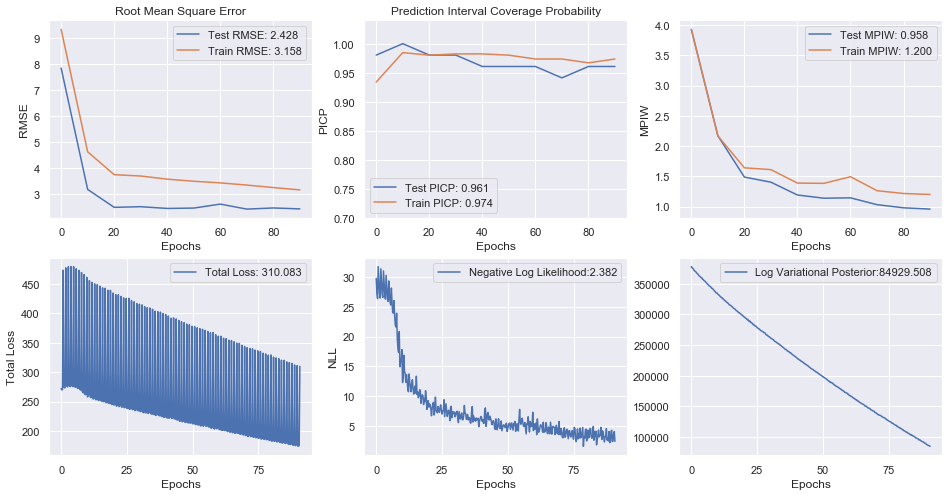

100%|██████████| 100/100 [01:23<00:00,  1.33it/s]


 RMSE = 2.414, PICP = 0.961, MPIW = 0.973


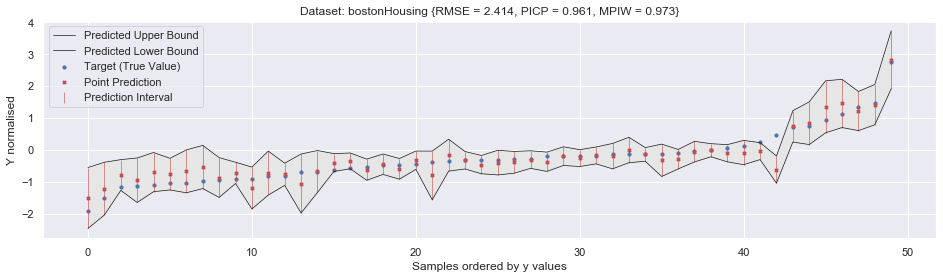

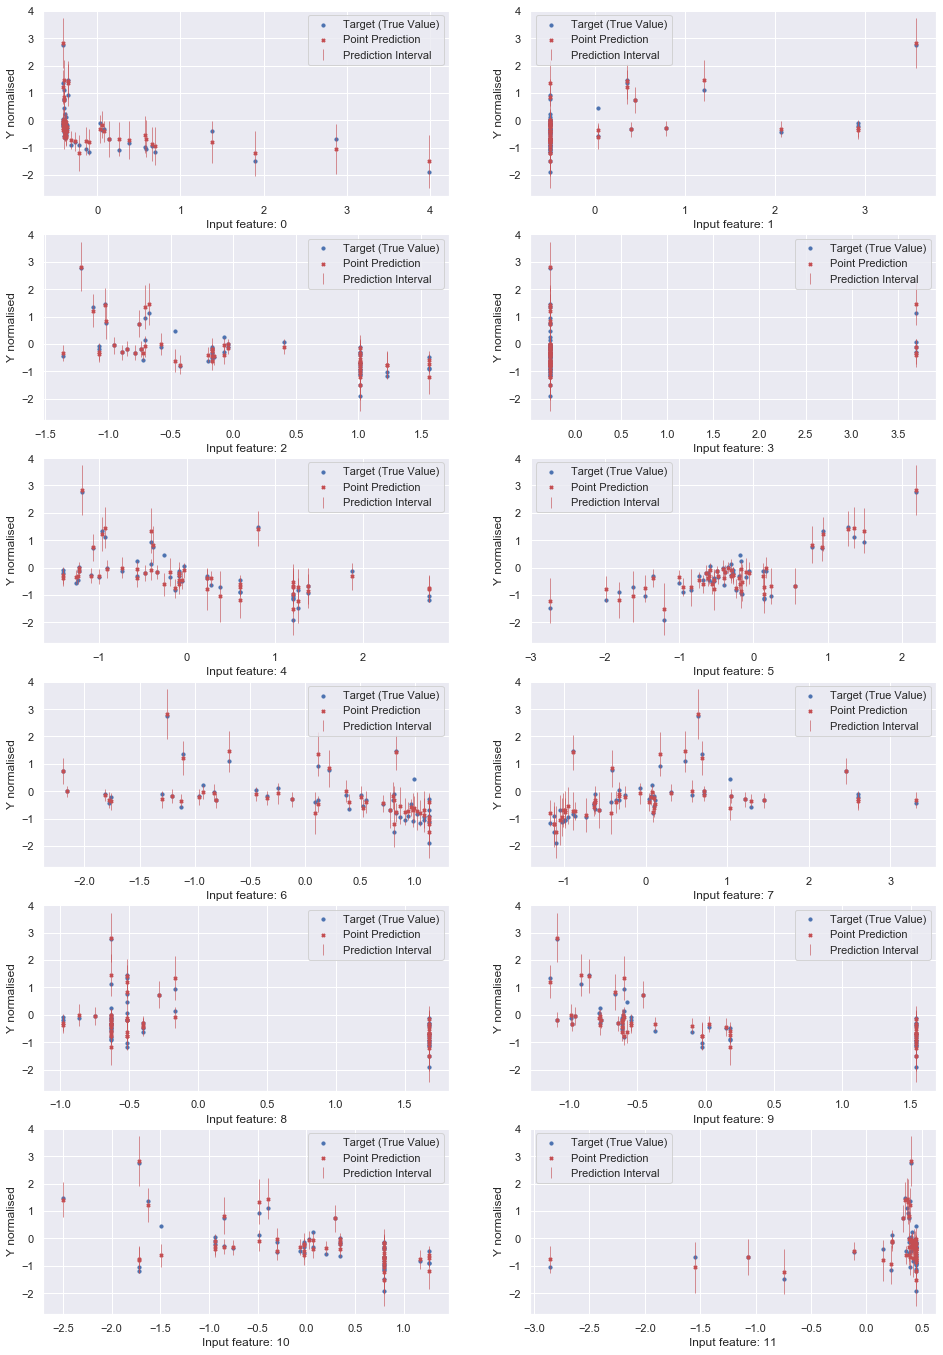

In [9]:
DATA_DIR="bostonHousing"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]


bostonHousing_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(bostonHousing_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(bostonHousing_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## Concrete

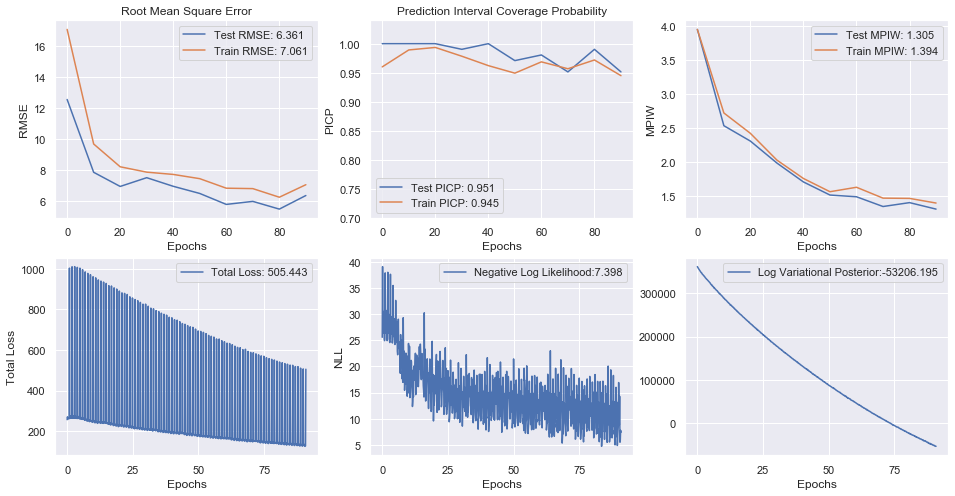

100%|██████████| 100/100 [02:31<00:00,  1.42s/it]


 RMSE = 6.680, PICP = 0.990, MPIW = 1.409


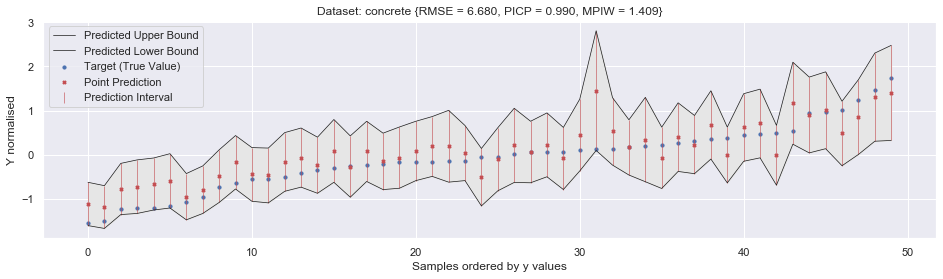

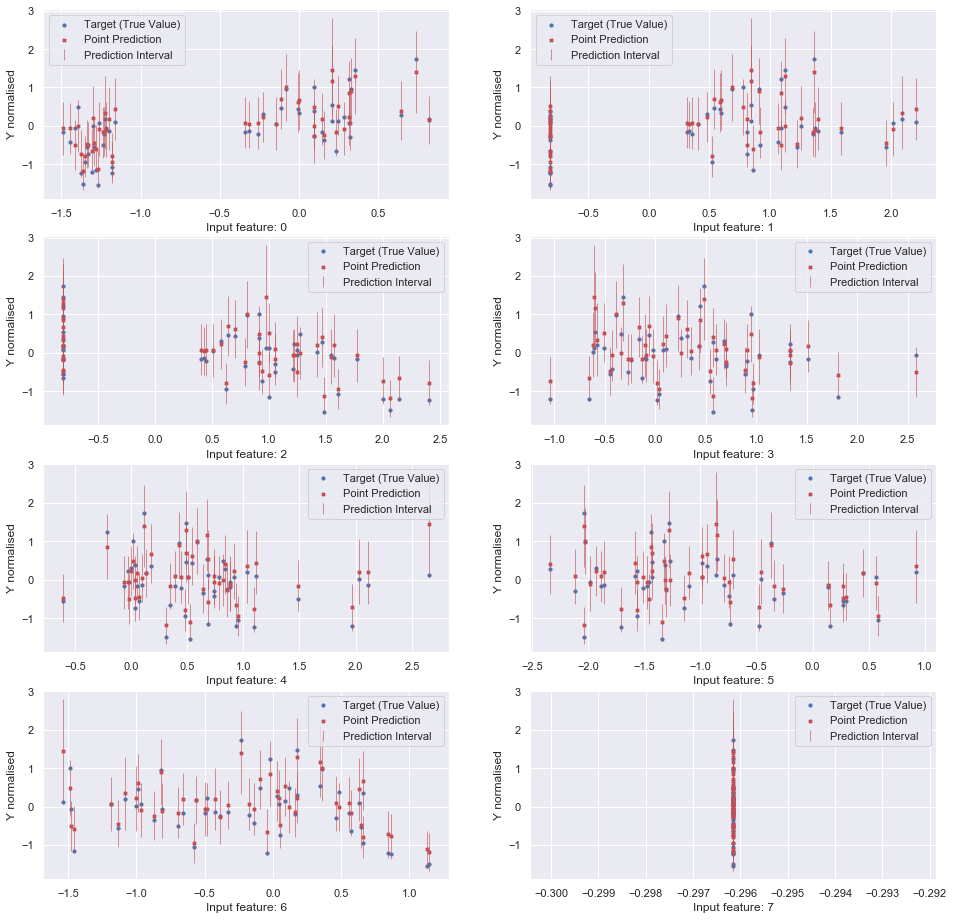

In [9]:
DATA_DIR="concrete"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]

concrete_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(concrete_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(concrete_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## energy_heating_load

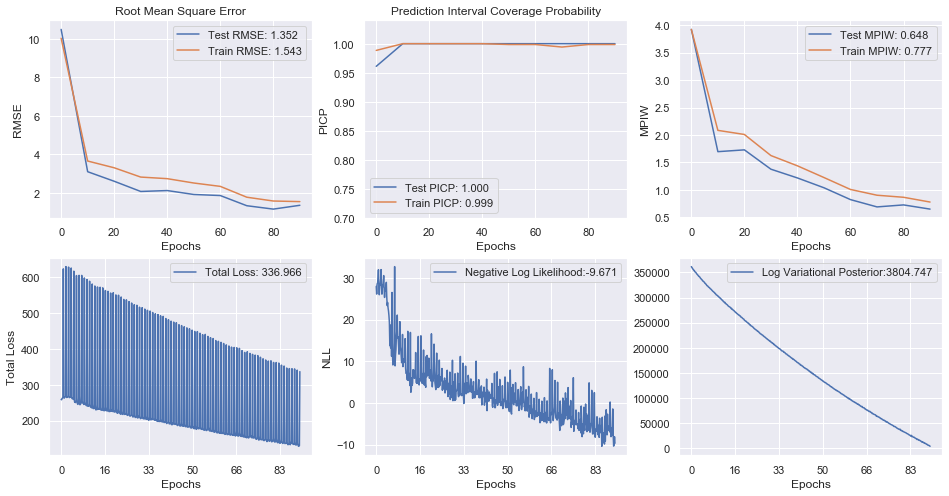

100%|██████████| 100/100 [01:57<00:00,  1.08s/it]


 RMSE = 1.065, PICP = 0.948, MPIW = 0.496


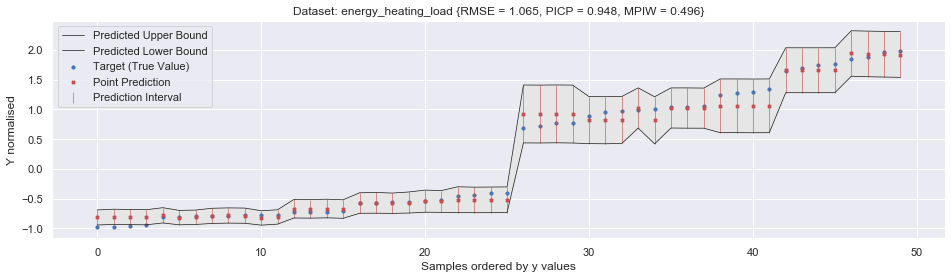

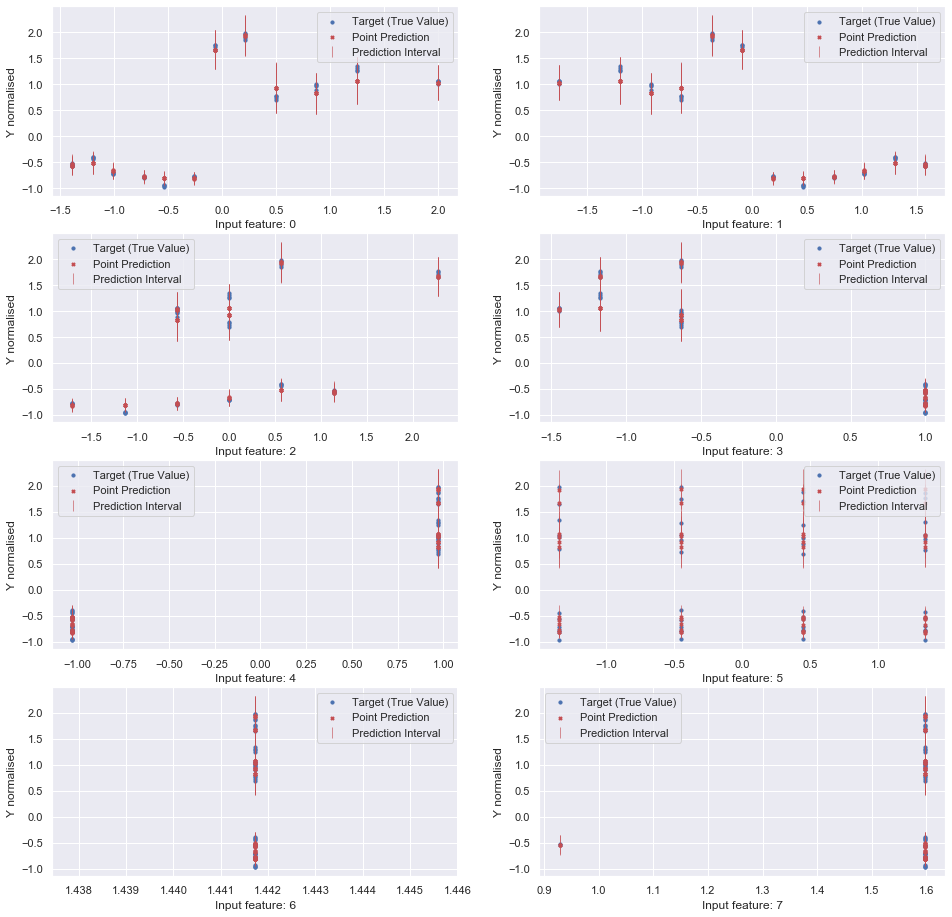

In [10]:
DATA_DIR="energy_heating_load"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]

energy_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(energy_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(energy_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)


## kin8nm

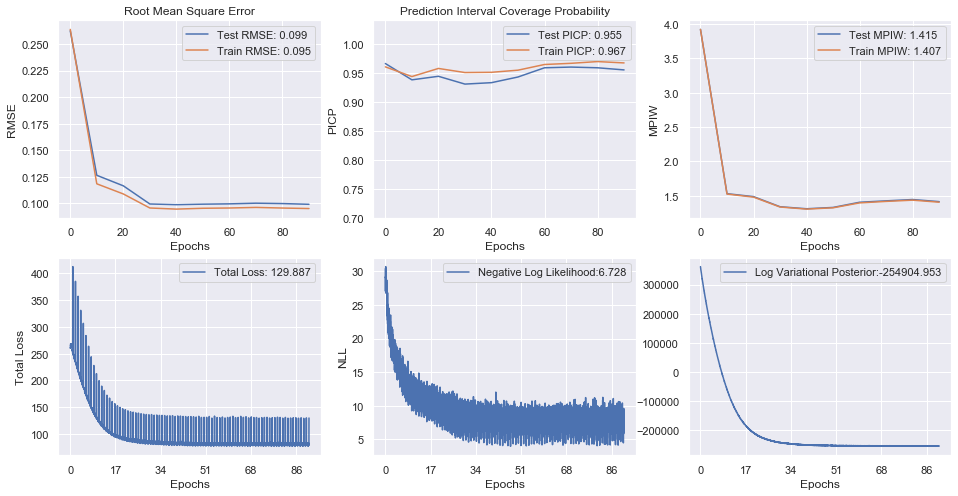

100%|██████████| 100/100 [17:04<00:00,  9.75s/it]


 RMSE = 0.098, PICP = 0.952, MPIW = 1.391


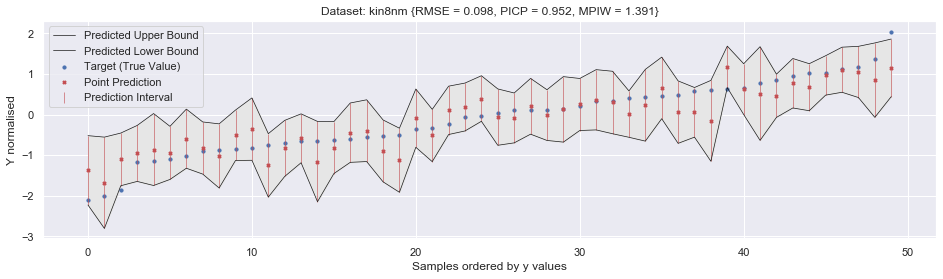

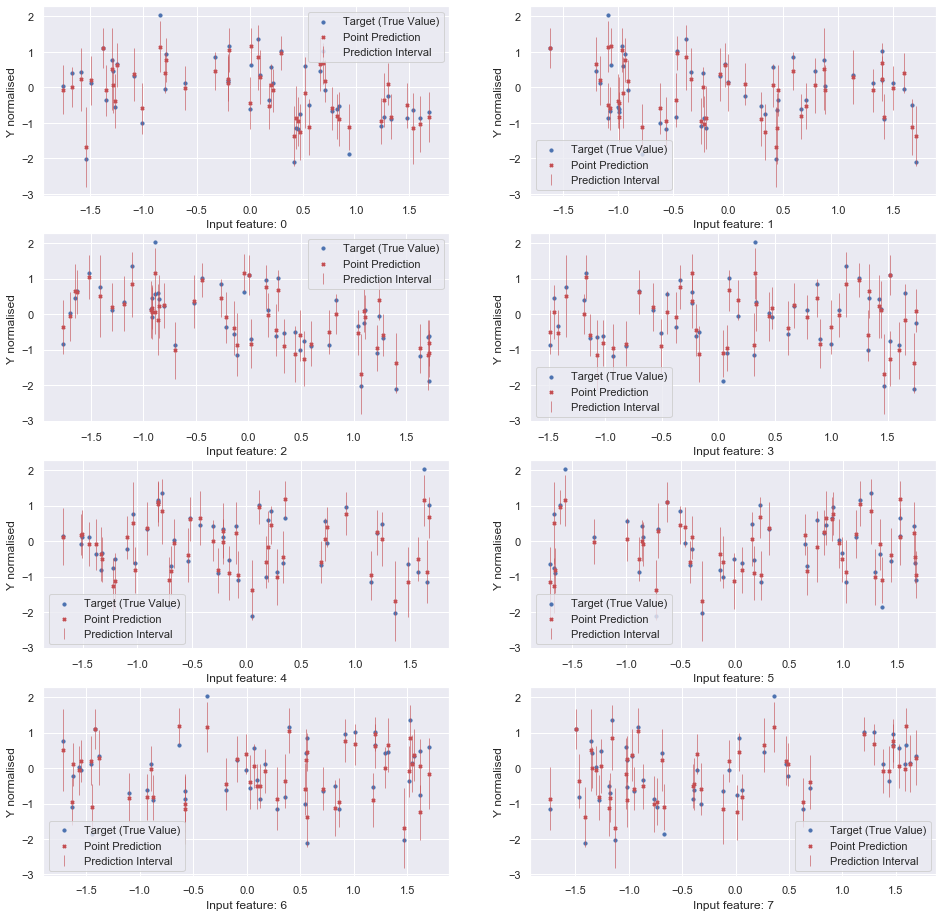

In [11]:
DATA_DIR="kin8nm"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]

kin8nm_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(kin8nm_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(kin8nm_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## naval-propulsion-plant

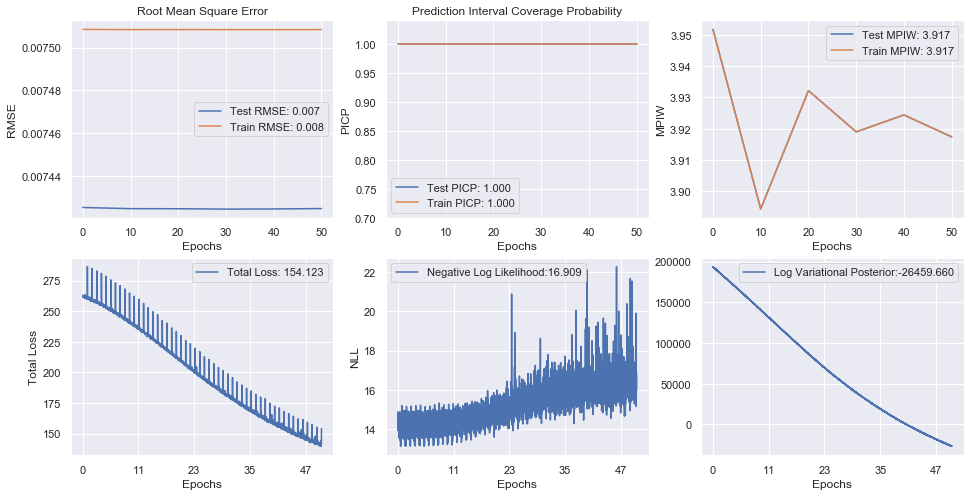

100%|██████████| 58/58 [07:50<00:00,  7.96s/it]


 RMSE = 0.007, PICP = 1.000, MPIW = 3.911


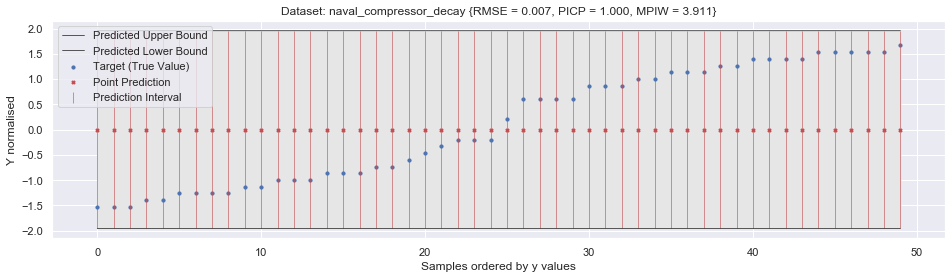

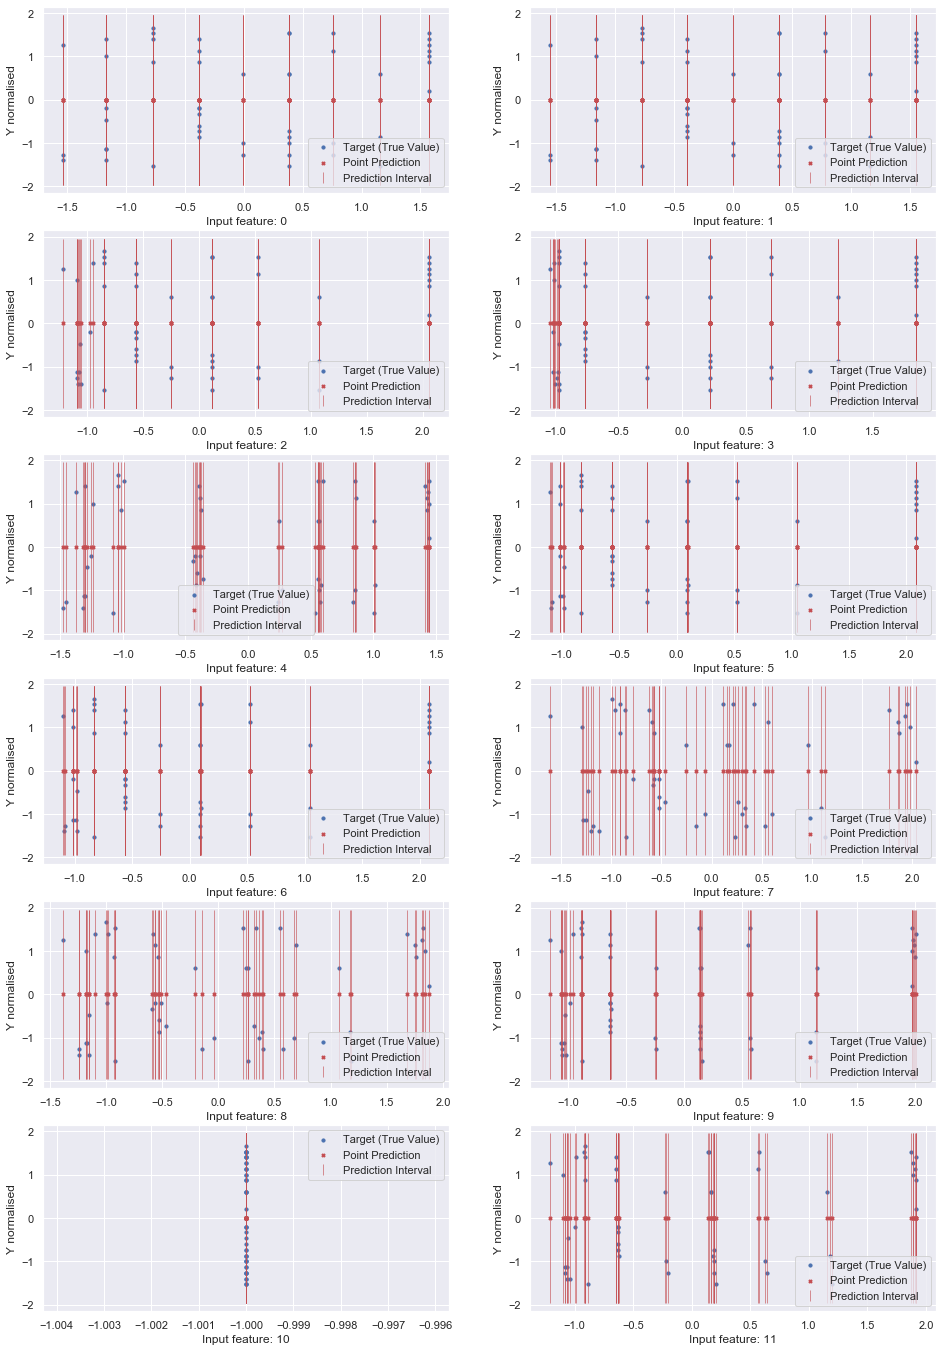

In [10]:
DATA_DIR="naval_compressor_decay"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]

naval_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(naval_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(naval_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## power

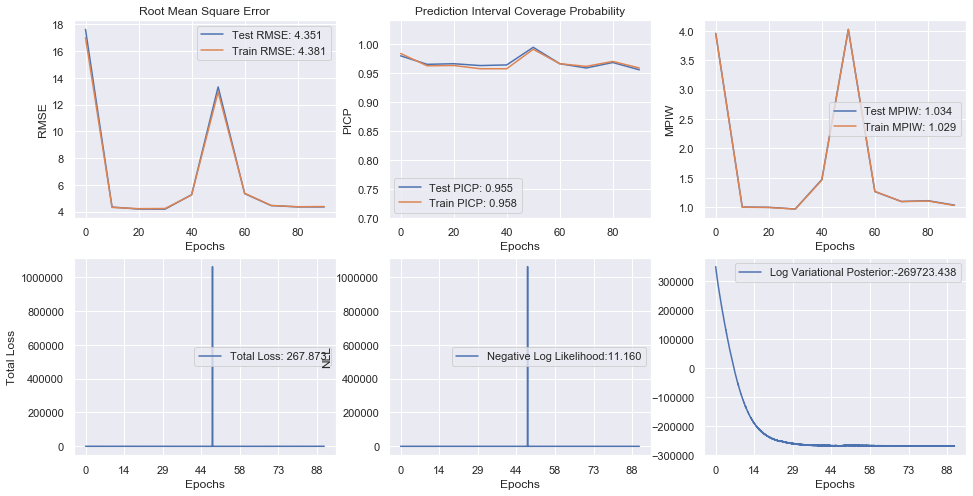

100%|██████████| 100/100 [20:19<00:00, 12.50s/it]


 RMSE = 4.709, PICP = 0.956, MPIW = 1.140


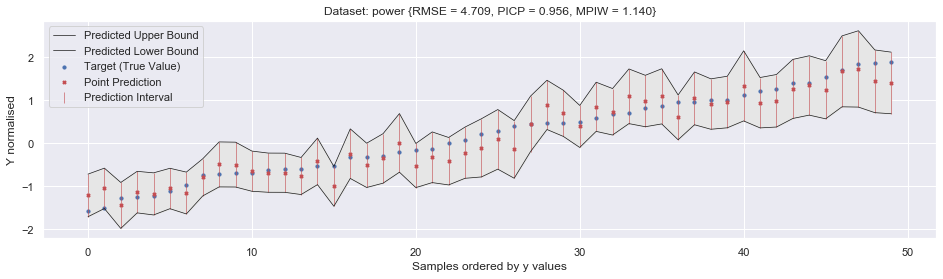

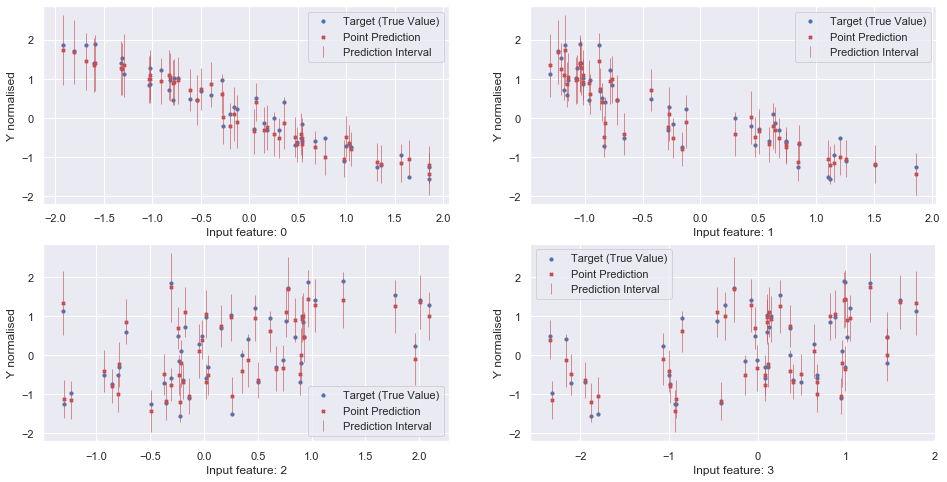

In [12]:
DATA_DIR="power"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]

power_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(power_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(power_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## protein

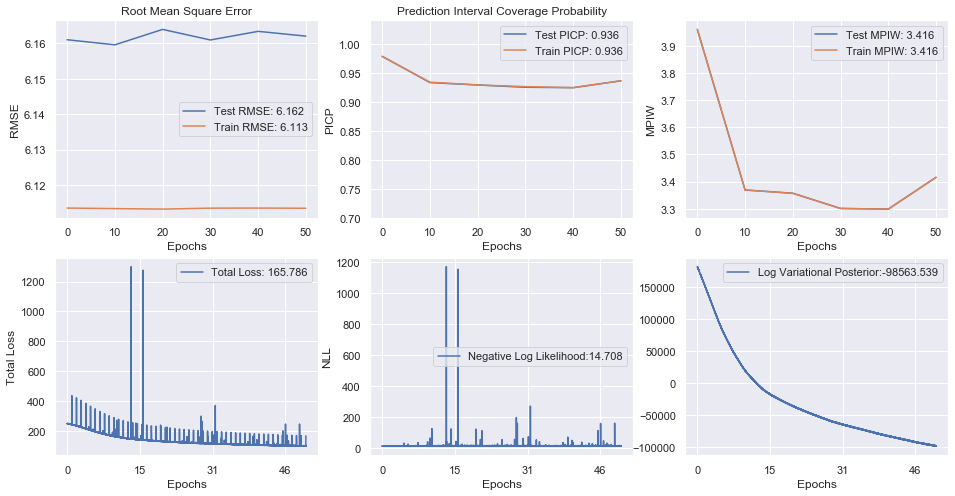

100%|██████████| 58/58 [29:05<00:00, 29.40s/it]


 RMSE = 6.162, PICP = 0.931, MPIW = 3.372


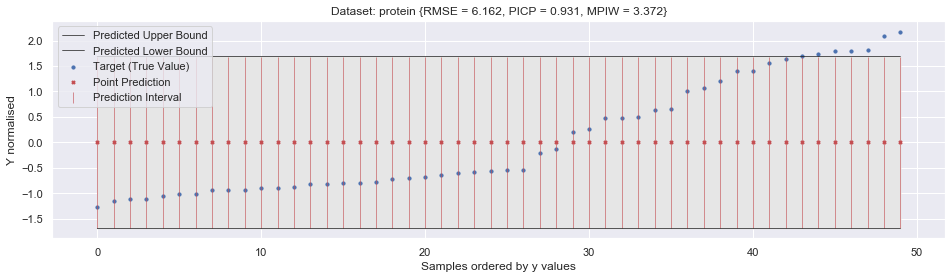

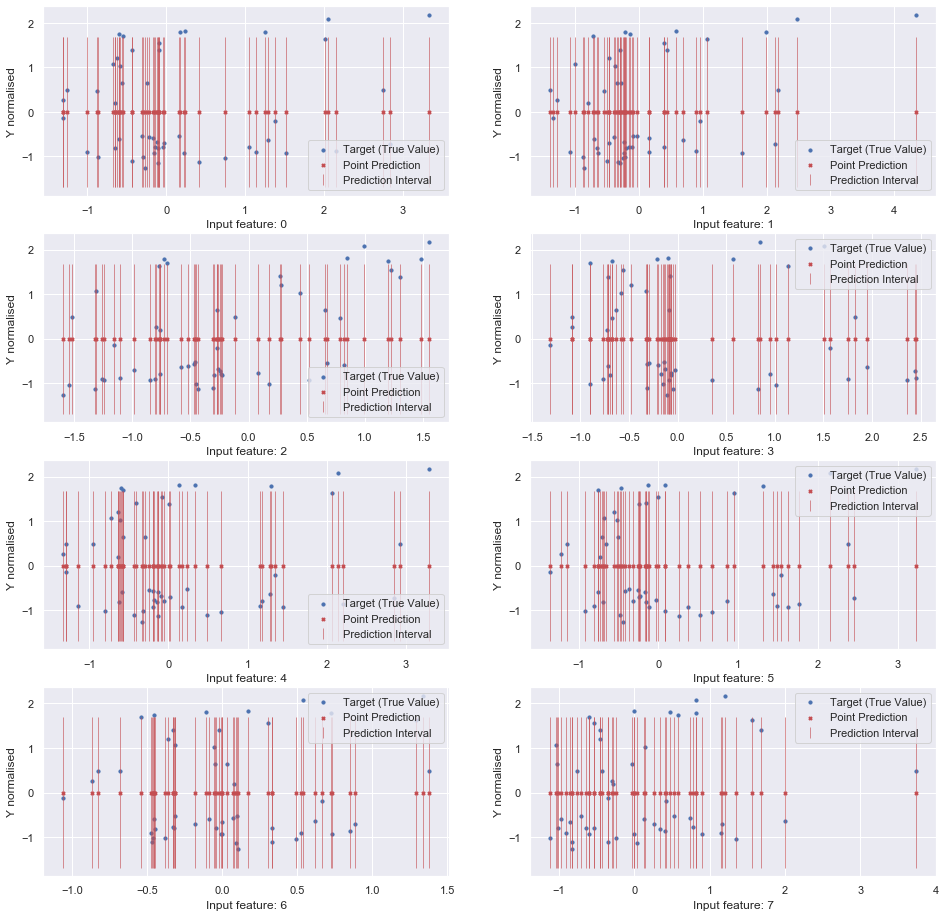

In [9]:

BATCH_SIZE =128
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 58
NUM_SAMPLES_TRAIN = 10
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95

learn_rate=1e-3
log_every=10
model_name='Bayes_LL'

DATA_DIR="protein"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]


protein_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(protein_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(protein_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)


## wine

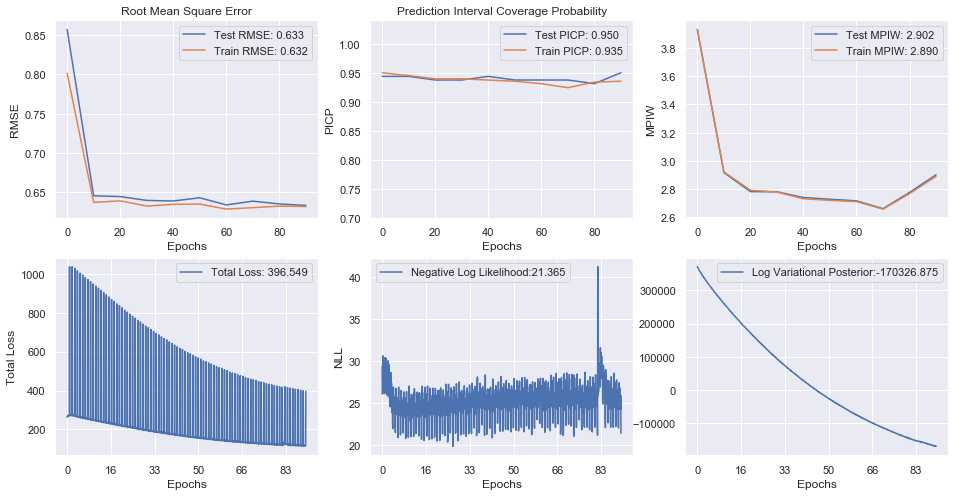

100%|██████████| 100/100 [03:29<00:00,  1.99s/it]


 RMSE = 0.633, PICP = 0.925, MPIW = 2.787


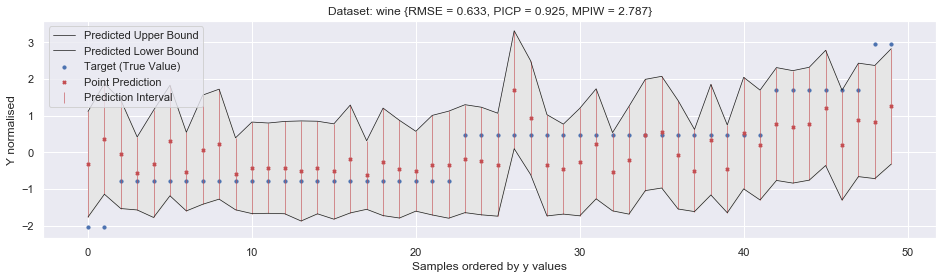

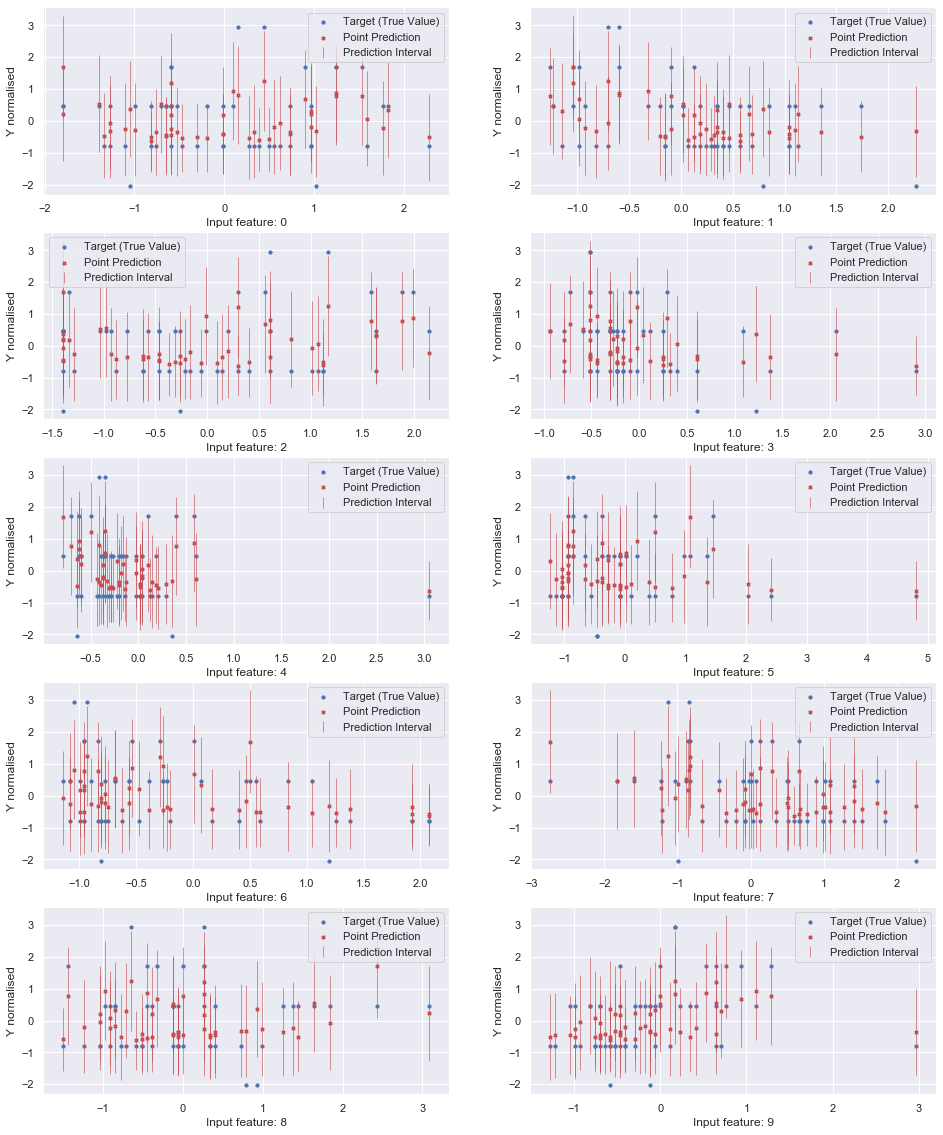

In [9]:
DATA_DIR="wine"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

wine_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(wine_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(wine_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## yacht

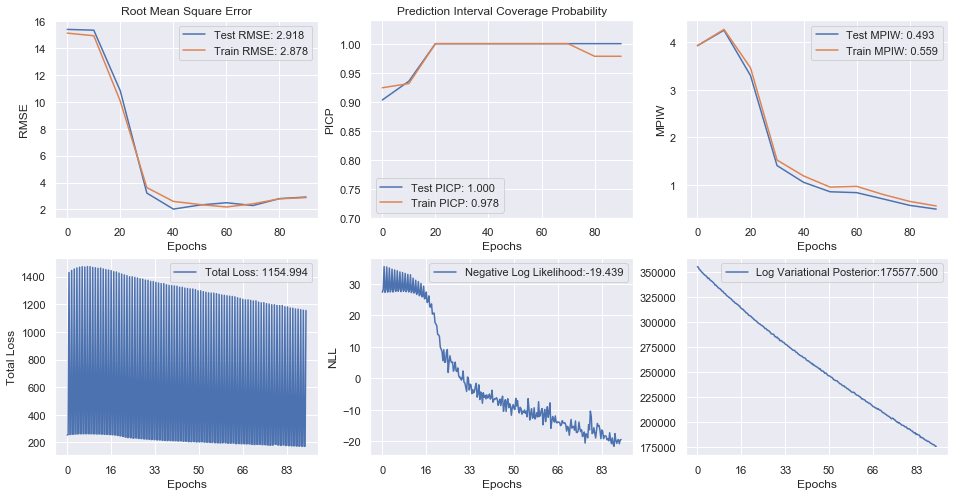

100%|██████████| 100/100 [01:00<00:00,  1.84it/s]


 RMSE = 3.246, PICP = 1.000, MPIW = 0.507


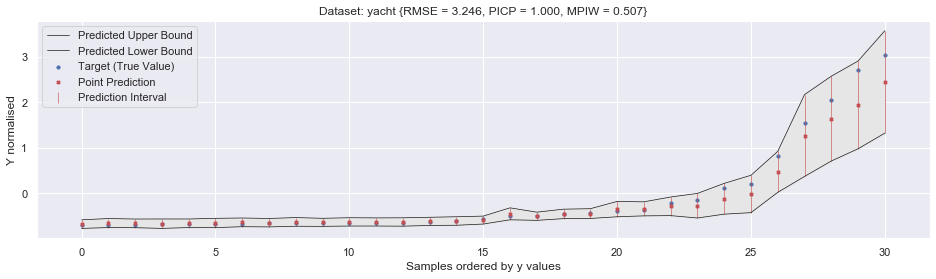

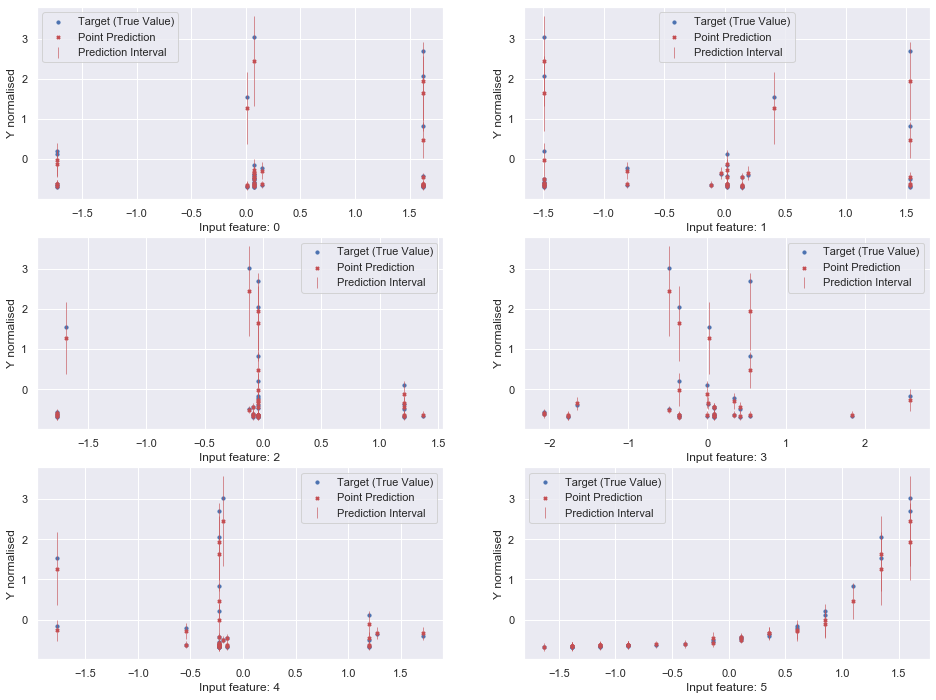

In [10]:
DATA_DIR="yacht"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

yacht_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(yacht_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(yacht_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## Year

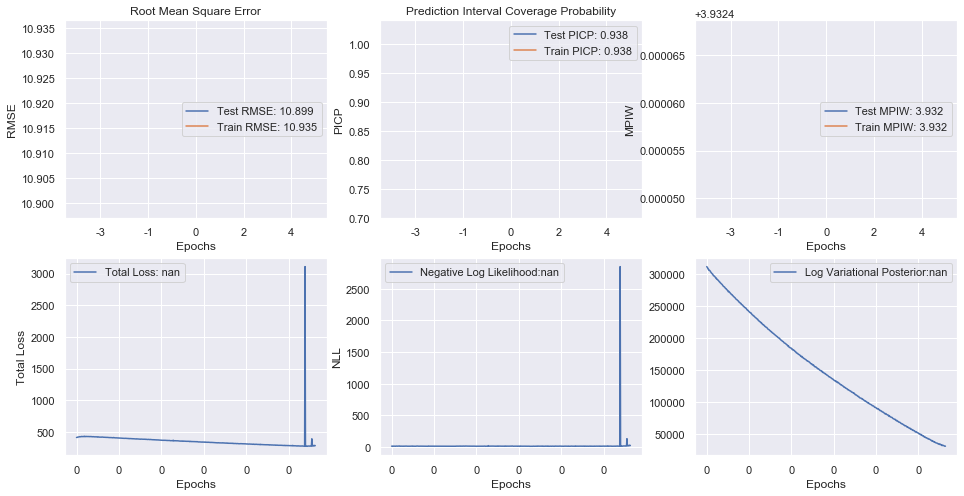

 17%|█▋        | 5/30 [33:22<2:47:09, 401.19s/it]

KeyboardInterrupt: 

In [18]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 80
NUM_SAMPLES_TRAIN = 10
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95

learn_rate=1e-2
log_every=100
model_name='Bayes_LL'




DATA_DIR="year_prediction_msd"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

year_model= BayesianNetwork_Model(network=BayesianNetwork(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS),
                                   learn_rate=learn_rate, 
                                   y_scale=y_scale)

train_Bayes(year_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(year_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)

